# Comparing linear regression, Ridge regression and Lasso

In this notebook,  linear regression with ridge regression and Lasso are compared using the <a href = "https://ww2.amstat.org/publications/jse/v19n3/decock.pdf"> Ames housing dataset.</a> The dataset contains the sale prices of houses in Ames, Iowa from 2006 to 2010, along with a number of different explanatory variables such as living area, neighborhood, street, year built, year remodeled, etc. This is a rich data set, containing around 3000 observations, and ideal to test (regularized) linear regression models. 

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.model_selection import cross_val_score
import matplotlib
%pylab inline
pd.options.display.max_columns = 300

Populating the interactive namespace from numpy and matplotlib


In [4]:
train = pd.read_csv("train.csv")
target = train["SalePrice"]
train = train.drop("SalePrice",1) # take out the target variable
test = pd.read_csv("test.csv")
combi = pd.concat((train,test)) # this is the combined data frame without the target variable

In [5]:
print(shape(train))
print(shape(test))
print(shape(combi))

(1460, 80)
(1459, 80)
(2919, 80)


### Data preprocessing

Check the distrution of sale prices (target) in linear space and in log-space.

Text(0.5,0,'log10(Sale Price in Dollar)')

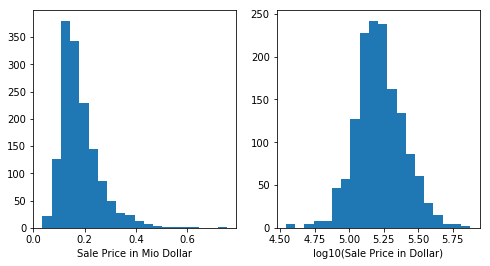

In [6]:
figure(figsize(8,4))
subplot(1,2,1)
hist(target*1e-6,20);
xlabel("Sale Price in Mio Dollar")
subplot(1,2,2)
hist(log10(target),20);
xlabel("log10(Sale Price in Dollar)")

We see that the target variable has a more symmetric distribution in log-space, which look much more Gaussian, and therefore we perform the following simple tranformation:

In [7]:
target = log10(target)

Next, let's look at some rows of the data. There are a lot of categorical data and NaN values, it's a bit of a mess:

In [8]:
combi.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732.0,Unf,0.0,64.0,796.0,GasA,Ex,Y,SBrkr,796,566,0,1362,1.0,0.0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2.0,480.0,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369.0,Unf,0.0,317.0,1686.0,GasA,Ex,Y,SBrkr,1694,0,0,1694,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2.0,636.0,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,GasA,Gd,Y,FuseF,1022,752,0,1774,0.0,0.0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2.0,468.0,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,M

To transform categorical variables  into numerical features, we will use ```get_dummies()```, and fill the missing values with the mean from each column using ```fillna```:

In [25]:
# create new features from categorical data:
combi = pd.get_dummies(combi)
# and fill missing entries with the column mean:
combi = combi.fillna(combi.mean())

# create the new train and test arrays:
train = combi[:train.shape[0]]
test = combi[train.shape[0]:]

In [26]:
combi.head(10)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,Gar

### Modeling

Wew will start with simple linear regression model.

In [27]:
model = LinearRegression()
score = mean(sqrt(-cross_val_score(model, train, target,scoring="neg_mean_squared_error", cv = 5)))
print("linear regression score: ", score)

('linear regression score: ', 0.06829560854676917)


Let's see if we can do better with regularized regression. For both Ridge and Lasso regression, we will vary the $\alpha$ parameter and evaluate the model as function of $\alpha$, using cross-validation:

('best score in Ridge: ', 0.06065251614495659)
('best score in Lasso: ', 0.05953136053640171)


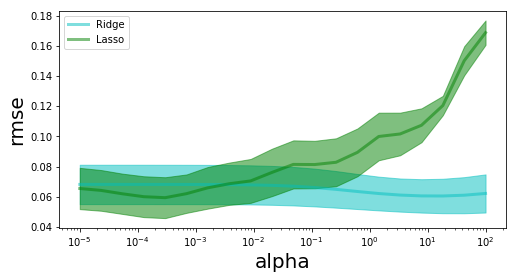

In [28]:
cv = 5 #number of folds in cross-validation

alphas = np.logspace(-5,2,20)
scores = np.zeros((len(alphas),cv))
scores_mu = np.zeros(len(alphas))
scores_sigma = np.zeros(len(alphas))

for i in range(0,len(alphas)):
    model = Ridge(alpha=alphas[i])
    scores[i,:] = sqrt(-cross_val_score(model, train, target,scoring="neg_mean_squared_error", cv = cv))
    scores_mu[i] = mean(scores[i,:])
    scores_sigma[i] = std(scores[i,:])

figure(figsize(8,4))   
#for i in range(0,cv):
#    plot(alphas,scores[:,i], 'b--', alpha=0.5)
plot(alphas,scores_mu,'c-',lw=3, alpha=0.5, label = "Ridge")
fill_between(alphas,np.array(scores_mu)-np.array(scores_sigma),
             np.array(scores_mu)+np.array(scores_sigma),color="c",alpha=0.5)

print("best score in Ridge: ",min(scores_mu))

for i in range(0,len(alphas)):
    model = Lasso(alpha=alphas[i])
    scores[i,:] = sqrt(-cross_val_score(model, train, target,scoring="neg_mean_squared_error", cv = cv))
    scores_mu[i] = mean(scores[i,:])
    scores_sigma[i] = std(scores[i,:])

plot(alphas,scores_mu,'g-',lw=3, alpha=0.5, label="Lasso")
fill_between(alphas,np.array(scores_mu)-np.array(scores_sigma),
             np.array(scores_mu)+np.array(scores_sigma),color="g",alpha=0.5)

xscale("log")
plt.xlabel("alpha", size=20)
plt.ylabel("rmse", size=20)
legend(loc=2)

print("best score in Lasso: ",min(scores_mu))

This plot shows the root mean squared error (rmse) as function  of alpha, for ridge regression (blue) and Lasso regression (green). In both cases we plot a band, corresponding to the variation in performance as determined in the different cross-validation folds.

We see that Lasso regression performs (on average) slightly better than Ridge regression when we choose $\alpha\sim10^{-4}$.

Finally, let us look at how many coefficients the Lasso algorithm sets to zero, as function of regularization parameter $\alpha$:

In [52]:
alphas = np.logspace(-5,2,20)
coeffs_zero = np.zeros(len(alphas))
coeffs_nonzero = np.zeros(len(alphas))
for i,alpha in enumerate(alphas):
    model = Lasso(alpha=alpha)
    model.fit(train,target)
    coeffs_zero[i] = len(find(model.coef_==0))
    coeffs_nonzero[i] = len(find(model.coef_!=0))

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 

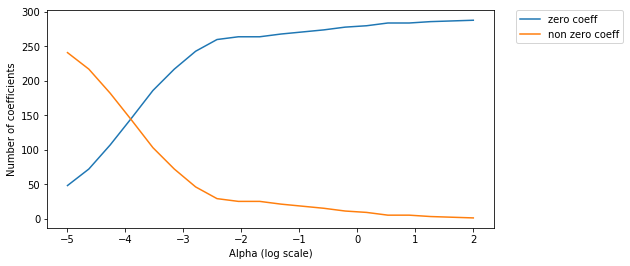

In [54]:
t = np.linspace(-5,2,20)
plt.plot(t, coeffs_zero, label="zero coeff")
plt.plot(t, coeffs_nonzero, label="non zero coeff")
plt.xlabel('Alpha (log scale)')
plt.ylabel('Number of coefficients')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We see that the larger we choose the regularization parameter, the more coefficients are set to zero (because they hit the "diamond edge"). For $\alpha=10^{-4}$, the best-performing model, roughly half of the regression coefficients are zero.

<b> Task:</b> Check the performance of OMP on this dataset.

In [ ]:
<b> Source:</b> Kaggle competition, 